## **`Saudi Arabia Used Cars`**

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# splitting data
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold

# preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# modeling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle

> #### **Contents**
1. **Business Understanding**
2. **Data Understanding**
3. **Data Preprocessing**
4. **Modeling**
5. **Conclusion**
6. **Recommendation**

> #### **Business Understanding**

**Context**

Saudi used cars are data about used cars in Saudi Arabia complete with various kinds of information such as brands, models, year of manufacture, vehicle origin, distance traveled and of course price. several variants of the car exist from 1963 to 2021.

**Problem**

The challenge of this problem is where the price of the car is negotiable, the price is not listed in this data or 0. So it is difficult for us to determine the appropriate price.

**Goals**

Therefore, using the capabilities of the computer, we can predict the price of car "0" according to the features available in this dataset.

**Analytics**

we need to analyze the data to get the pattern according to the existing features by making a regression model in order to predict the price as accurately as possible.

**Metrics**

The metrics that will be used in this process are RMSE / Root Mean Square error, MAE / Mean Absolute Error and MAPE / Mean Absolute Precentage Error. By finding the smallest value in these metrics, the data can be predicted as accurately as possible.

> #### **Data Understanding**

Used Cars Prices and Spec Scraped From Syarah Website

[Saudi Used Cars](https://drive.google.com/file/d/1Tr4YT5dmgwTrXLvIqZ4diBf5z8K6JjrR/view)

Attributes Information

- `Model`           : Name of a car product
- `Region`          : The region in which the used car was offered for sale 
- `Brand`           : Name of the car company
- `Transmission`    : Automatic / Manual 
- `Origin`          : Country of importer (Gulf/Saudi/Other) 
- `Options`         : Full Options/Semi-Full/Standard 
- `Year`            : Year of Manufacturing 
- `Engine`          : The engine size 
- `Mileage`         : The average distance that a vehicle can travel on (in km) 
- `Negotiable`      : If True, the price is 0. This means the price is negotiable (not set) 
- `Price`           : Price of the used car (in SAR) 

In [2]:
# load data & preview
cars = pd.read_csv('data_saudi_used_cars.csv')
cars.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


In [3]:
# check datatypes
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


> #### **EDA & Data Preprocessing**

In this process, we will perform several data cleaning and manipulation processes so that we can get the best possible data that will be used in the analysis process. This process includes feature drop, rename and data selection.

In [4]:
# Check attribute details
listItem = []

for col in cars.columns:
    listItem.append([col, cars[col].dtype, cars[col].isna().sum(), round((cars[col].isna().sum()/len(cars[col]))*100, 2),
                    cars[col].nunique(), list(cars[col].drop_duplicates().sample(2).values)]);

cars_desc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
cars_desc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Type,object,0,0.0,347,"[Accord, Envoy]"
1,Region,object,0,0.0,27,"[Al-Medina, Al-Baha]"
2,Make,object,0,0.0,58,"[Škoda, Dodge]"
3,Gear_Type,object,0,0.0,2,"[Automatic, Manual]"
4,Origin,object,0,0.0,4,"[Unknown, Gulf Arabic]"
5,Options,object,0,0.0,3,"[Standard, Semi Full]"
6,Year,int64,0,0.0,50,"[2001, 1977]"
7,Engine_Size,float64,0,0.0,71,"[8.9, 7.2]"
8,Mileage,int64,0,0.0,1716,"[293, 222]"
9,Negotiable,bool,0,0.0,2,"[True, False]"


From the existing data, there are several treatments that we need, such as removing the negotiable feature, changing the column name to make it easier to understand.
There are several features that already look good, such as no missing values, appropriate data types.

**Drop Columns**

Features available in this dataset, the `Negotiable` feature cannot provide helpful information therefore feature removal can be performed.

In [5]:
# drop irrelevant feature
cars.drop(['Negotiable'], axis=1, inplace=True)

**Rename Columns**

There are some column headings that seem less familiar, therefore it is necessary to change the column names to make them easier to understand.

In [6]:
# rename columns
cars.rename({'Type':'Model', 'Make':'Brand', 'Gear_Type':'Transmission', 'Engine_Size':'Engine'}, inplace=True, axis=1)

**Duplicate Data**

There is duplicate data, so the deletion of a duplicate must be done.

In [7]:
# check duplicate
cars.duplicated().sum()

4

In [8]:
# drop duplicated data
cars.drop_duplicates(inplace=True)
cars.duplicated().sum()

0

**Missing Value**

So far there is no missing value in this dataset, therefore no treatment must be done. However, we need to look at each unique feature in order to ensure that there are no missing values. there are some datasets that fill the empty column with "0".

In [9]:
# check missing value
cars.isna().sum()

Model           0
Region          0
Brand           0
Transmission    0
Origin          0
Options         0
Year            0
Engine          0
Mileage         0
Price           0
dtype: int64

**Summary statistics**

In [10]:
cars.describe()

,Year,Engine,Mileage,Price
count,5620.000000,5620.000000,5.620000e+03,5620.000000
mean,2014.100356,3.296299,1.509222e+05,53086.404448
std,5.793003,1.515253,3.829633e+05,70175.153207
min,1963.000000,1.000000,1.000000e+02,0.000000
25%,2012.000000,2.000000,3.800000e+04,0.000000
50%,2016.000000,3.000000,1.030000e+05,36500.000000
75%,2018.000000,4.500000,1.960000e+05,73000.000000
max,2022.000000,9.000000,2.000000e+07,850000.000000


In [11]:
cars.describe(exclude='number')

,Model,Region,Brand,Transmission,Origin,Options
count,5620,5620,5620,5620,5620,5620
unique,347,27,58,2,4,3
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full
freq,269,2270,1430,4871,4184,2232


Toyota Land Cruiser most people used cars in Saudi Arabia

**Correlation**

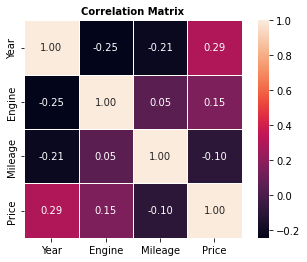

In [12]:
corr = cars.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f', square=True, linewidths=.5)
plt.title('Correlation Matrix', size=10, weight='bold');

The `Year` feature shows a high correlation with Price with a value of 0.29, therefore it can be said that the price of a car will be higher if the year is increasing.

**Outliers**

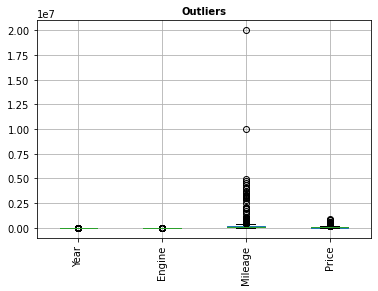

In [13]:
cars.boxplot(rot=90)
plt.title('Outliers', size=10, weight='bold')
plt.show()

It can be seen that there are outliers in the `Mileage` and `Price` features, therefore a treatment is needed in order to minimize the existing outliers.
Outliers can bias the results in an analysis.

In [14]:
# outliers
def find_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'IQR      : {iqr}')

    minimum = q1 - limit
    maximum = q3 + limit
    print(f'Minimum  : {minimum}')
    print(f'Maximum  : {maximum}')

find_outliers(cars['Price'])  

IQR      : 73000.0
Minimum  : -109500.0
Maximum  : 182500.0


**Price**

In [15]:
# describe statistics
cars['Price'].describe()

count      5620.000000
mean      53086.404448
std       70175.153207
min           0.000000
25%           0.000000
50%       36500.000000
75%       73000.000000
max      850000.000000
Name: Price, dtype: float64

In [16]:
cars = cars[(cars['Price'] != 0)]

In [17]:
# check total outliers
cars[(cars['Price'] == 0) | (cars['Price'] > 182500)]['Price'].count()

261

In [18]:
# filter outlier
cars = cars[(cars['Price'] != 0) & (cars['Price'] < 182500)]

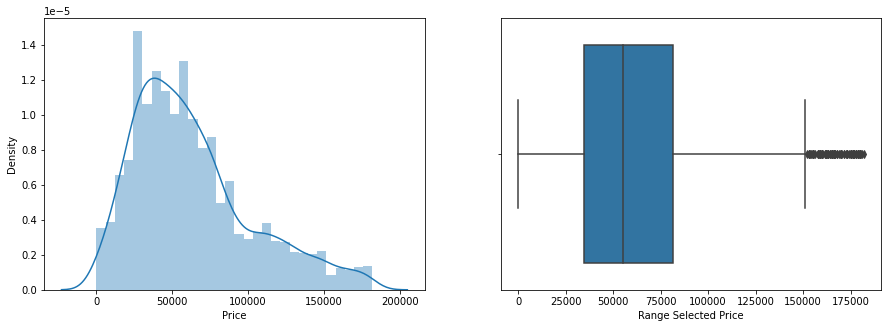

In [19]:
# visualize filtered price
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.distplot(cars['Price'], ax=axes[0])
sns.boxplot(cars['Price'], ax=axes[1])
axes[0].set_xlabel('Price')
axes[1].set_xlabel('Range Selected Price');

**Mileage**

In [20]:
# outliers
def find_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'IQR      : {iqr}')

    minimum = q1 - limit
    maximum = q3 + limit
    print(f'Minimum  : {minimum}')
    print(f'Maximum  : {maximum}')

find_outliers(cars['Mileage'])  

IQR      : 136000.0
Minimum  : -150000.0
Maximum  : 394000.0


In [21]:
# describe statistics
cars['Mileage'].describe()

count    3.563000e+03
mean     1.490924e+05
std      3.909648e+05
min      1.000000e+02
25%      5.400000e+04
50%      1.080000e+05
75%      1.900000e+05
max      2.000000e+07
Name: Mileage, dtype: float64

In [22]:
# check total outliers
cars[cars['Mileage'] > 387500]['Mileage'].count()

130

In [23]:
# filter outlier
cars = cars[cars['Mileage'] < 387500]

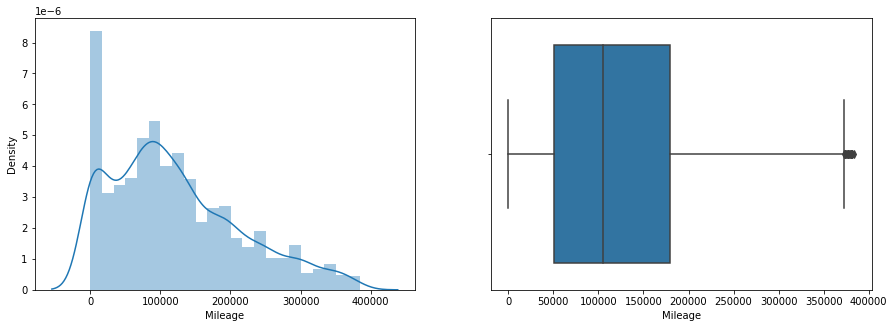

In [24]:
# visualize filtered mileage
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.distplot(cars['Mileage'], ax=axes[0])
sns.boxplot(cars['Mileage'], ax=axes[1])
axes[0].set_xlabel('Mileage')
axes[1].set_xlabel('Mileage');

**Most Region**

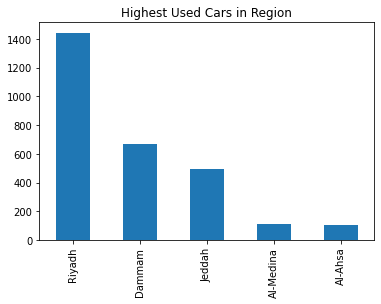

In [25]:
cars['Region'].value_counts(ascending=False).head().plot.bar()
plt.title('Highest Used Cars in Region')
plt.show()

It can be seen that the city of Riyadh has the most total used cars followed by Dammam and Jeddah. With this information, it is possible that the price of a car can be cheaper with the same type of model in Riyadh compare to another. but we need to explore further.

**Top Brands**

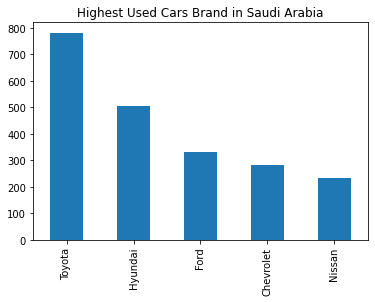

In [26]:
cars['Brand'].value_counts(ascending=False).head().plot.bar()
plt.title('Highest Used Cars Brand in Saudi Arabia')
plt.show()

Toyota the highest brands used cars. this means that the best-selling car brand is Toyota and most likely the price should be stable for a used car sale.

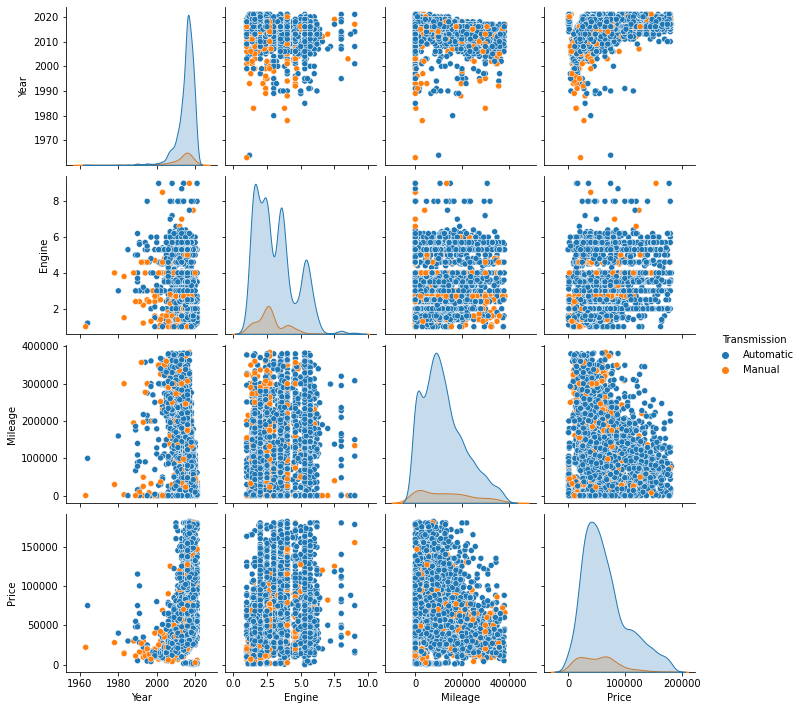

In [27]:
# visualize relationships
sns.pairplot(cars, hue='Transmission')
plt.show()

**Cleaned Data Preview**

In [28]:
cars.head()

,Model,Region,Brand,Transmission,Origin,Options,Year,Engine,Mileage,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,120000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,42000
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,58000
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,85000
7,Sonata,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,48000


In [29]:
cars.describe(include='all')

,Model,Region,Brand,Transmission,Origin,Options,Year,Engine,Mileage,Price
count,3433,3433,3433,3433,3433,3433,3433.000000,3433.000000,3433.000000,3433.000000
unique,304,27,54,2,4,3,NaN,NaN,NaN,NaN
top,Accent,Riyadh,Toyota,Automatic,Saudi,Standard,NaN,NaN,NaN,NaN
freq,146,1443,782,3079,2645,1270,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.932712,3.095223,121676.452957,64044.798427
std,NaN,NaN,NaN,NaN,NaN,NaN,4.840867,1.436116,92518.849821,39353.848211
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,100.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,2.000000,51000.000000,35000.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,2.700000,105000.000000,55000.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.000000,179600.000000,83000.000000


In [30]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433 entries, 1 to 5622
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Model         3433 non-null   object 
 1   Region        3433 non-null   object 
 2   Brand         3433 non-null   object 
 3   Transmission  3433 non-null   object 
 4   Origin        3433 non-null   object 
 5   Options       3433 non-null   object 
 6   Year          3433 non-null   int64  
 7   Engine        3433 non-null   float64
 8   Mileage       3433 non-null   int64  
 9   Price         3433 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 424.1+ KB


After going through several processes such as preprocessing and feature engineering. This data can be concluded with the above information and can then be carried out in the modeling process.

>#### **Modeling**

**Encoding**

This process is needed to convert categorical data into numeric, this is because in the modeling process only numeric data can be accepted.

In [31]:
# encode categorical
transformer = ColumnTransformer([
    ('One Hot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Region','Brand','Transmission','Origin','Options']),
    ('Binary', ce.BinaryEncoder(), ['Model'])
], remainder='passthrough')

**Splitting**

Separate independent variable with target

In [32]:
# splitting
X = cars.drop(['Price'], axis=1)
y = cars['Price']

**Train Test Splitt**

Splitting test and train set to 70:30 proportion

In [33]:
# splitting 
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,  
    test_size=0.3,
    random_state=0)

**Models**

In [34]:
# algorithm
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)
xgb = XGBRegressor(random_state=0)

In [35]:
# modeling
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)

In [36]:
# scaling
scaler = StandardScaler(with_mean=False)

In [37]:
# algorithm
models = [log_lr, log_knn, log_dt, log_rf, log_xgb]

score_rmse = []
value_mean_rmse = []
value_std_rmse = []

score_mae = []
value_mean_mae = []
value_std_mae = []

score_mape = []
value_mean_mape = []
value_std_mape = []

In [38]:
# find best model based on mae
for i in models:
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=0)

    estimator = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', i)
    ])

    model_cv_rmse = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    value_mean_rmse.append(model_cv_rmse.mean())
    value_std_rmse.append(model_cv_rmse.std())

    model_cv_mae = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    value_mean_mae.append(model_cv_mae.mean())
    value_std_mae.append(model_cv_mae.std())

    model_cv_mape = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_percentage_error', 
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    value_mean_mape.append(model_cv_mape.mean())
    value_std_mape.append(model_cv_mape.std())

[-26344.0285231  -28874.87917669 -27524.92492207 -27930.22498351
 -29213.28992968] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-18426.06974508 -20119.08480311 -19327.68164343 -19179.85015875
 -20779.72709257] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-194.86561763   -1.26094629   -1.13218056   -0.91341882   -1.20519795] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-30628.31932511 -28563.32671858 -31967.73930322 -29010.55825929
 -30482.35453057] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=KNeighborsRegressor())
[-21623.801183   -20863.59389863 -22261.59235158 -20312.02935434
 -21465.18019063] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufun

In [39]:
# evaluation
pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regressor', 'DecisionTree Regressor', 'RandomForest Regressor', 'XGBoost Regressor'],
    'Mean_RMSE': value_mean_rmse,
    'Std_RMSE': value_std_rmse,
    'Mean_MAE': value_mean_mae,
    'Std_MAE': value_std_mae,
    'Mean_MAPE': value_mean_mape,
    'Std_MAPE': value_std_mape
})

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
0,Linear Regression,-27977.469507,1020.563994,-19566.482689,810.479292,-39.875472,77.495163
1,KNN Regressor,-30130.459627,1221.259640,-21305.239396,666.811904,-12.920683,23.493391
2,DecisionTree Regressor,-30384.819175,1480.932475,-18780.536757,1052.140349,-56.123652,109.655979
3,RandomForest Regressor,-24250.011433,1293.287990,-14970.161057,711.092955,-27.671782,53.271254
4,XGBoost Regressor,-22899.540274,1868.273553,-14575.245782,641.690587,-47.053542,91.964471


From the information above, it can be seen that the performance of RandomForest and XGBoost is very good. it is evident from the difference in values which is quite far from some other models. therefore we focus on only 2 models.

**Benchmarking**

In [40]:
# benchmarking
models = {
    'XGB': XGBRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(random_state=0)
}

score_rmse = []
score_mae = []
score_mape = []

# prediction test-set
for i in models:

    model = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
before_tuning

,RMSE,MAE,MAPE
XGB,18559.155674,11887.295715,0.834737
RandomForest,19566.611633,12159.216050,0.894698


**Hyperparameter Tuning**

In [41]:
max_depth = list(np.arange(1, 11))
learning_rate = list(np.arange(1, 100)/100)
n_estimators = list(np.arange(100, 201))
subsample = list(np.arange(2, 10)/10)
gamma = list(np.arange(1, 11)) 
colsample_bytree = list(np.arange(1, 10)/10)
reg_alpha = list(np.logspace(-3, 1, 10)) # Semakin besar nilainya, semakin konservatif/simpel modelnya

In [42]:
hyperparam_space_xgb = {
    'model__max_depth': max_depth, 
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
    'model__gamma': gamma,
    'model__colsample_bytree': colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [43]:
xgb = XGBRegressor(random_state=0, verbosity=0)

estimator_xgb = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', xgb)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=0)

In [44]:
# hyperparameter tuning
random_xgb = RandomizedSearchCV(
    estimator_xgb, 
    param_distributions = hyperparam_space_xgb,
    n_iter = 50,
    cv = crossval, 
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error',
    random_state = 0  
)

In [45]:
# fitting training data
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('One '
                                                                               'Hot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['Region',
                                                                                'Brand',
                                                                                'Transmission',
                                                                                'Origin',
              

In [46]:
# tuning score
pd.DataFrame(random_xgb.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
3,0.655437,0.026460,0.045774,0.010828,0.5,0.059948,142,5,0.18,6,...,351.465647,2,-266.294079,-1.237147,-1.380688,-0.945593,-1.195636,-54.210629,106.041818,30
6,0.830735,0.074789,0.049874,0.008157,0.9,3.593814,168,5,0.22,3,...,390.424234,1,-252.543774,-1.300679,-1.389077,-0.952836,-1.158600,-51.468993,100.537498,20
21,0.967154,0.027122,0.054769,0.006010,0.7,0.021544,160,10,0.14,9,...,643.243385,3,-277.281729,-1.274114,-1.388297,-0.935107,-1.128720,-56.401593,110.440172,34
5,1.167048,0.080667,0.082954,0.021266,0.5,0.007743,190,8,0.1,5,...,406.978326,5,-292.889961,-1.307190,-1.359732,-0.944666,-1.136568,-59.527624,116.681259,41
30,0.421064,0.007119,0.033582,0.001853,0.9,10.0,109,4,0.44,5,...,246.883399,6,-225.534649,-1.265369,-1.364505,-0.937761,-1.112903,-46.043038,89.745922,9


In [47]:
# best params
print('XGBoost')
print('Best_score:', random_xgb.best_score_)
print('Best_params:', random_xgb.best_params_)

XGBoost
Best_score: -20116.72934622994
Best_params: {'model__subsample': 0.5, 'model__reg_alpha': 0.05994842503189409, 'model__n_estimators': 142, 'model__max_depth': 5, 'model__learning_rate': 0.18, 'model__gamma': 6, 'model__colsample_bytree': 0.6}


**Predict to Test Set with the Tuned Model**

In [48]:
# model xgboost
model = {'XGB': XGBRegressor(random_state=0)}

# best estimator
xgb_tuning = random_xgb.best_estimator_

# fitting model
xgb_tuning.fit(X_train, y_train)

# predict test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# assign score
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

after_tuning = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=model.keys())
after_tuning

,RMSE,MAE,MAPE
XGB,18388.764113,11887.863607,0.800503


It can be seen that the RMSE and MAPE tuning results are slightly better, although not for MAE.

**Feature Importances**

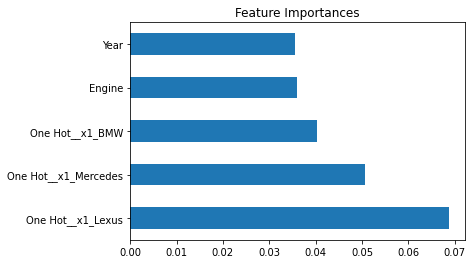

In [49]:
# visualize feature importances
feature_imp = pd.Series(xgb_tuning['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head()
feature_imp.plot(kind='barh', title='Feature Importances');

> #### **Conclusion**

Based on the results of the modeling process, it can be seen that the `Brand`, `Engine` and `Year` features have a very significant influence on the `Price` feature.
And it can be concluded that this model can predict the price of a used car in a maximum price range of 182500 Riyal with an average estimate of 18388.76 Riyal miss the average price. Due to the high bias, the possibility of missing is also quite high. maybe with some other features that might be very helpful.

> #### **Recommendation**

- By increasing the number of datasets it may help in modeling results, the lack of variation in the data may lead to decreased accuracy in making predictions
- Adding new features such as fit conditions and engine health may have a positive impact on the model
- Maybe every prediction result of this model can be directly confirmed its accuracy against the actual price in order to increase the precision in prediction.

#### **Save Model**

In [50]:
# save model
estimator = Pipeline([('preprocess', transformer), ('model', XGBRegressor())])
estimator.fit(X_train, y_train)

pickle.dump(estimator, open('Model_Saudi_Arabia_Used_Cars_XGB.sav', 'wb'))

In [51]:
# # load model
# filename = 'Model_Saudi_Arabia_Used_Cars_XGB.sav'
# loaded_model = pickle.load(open(filename, 'rb'))

Thank You - James Nainggolan